Practical assignment

The Microsoft Research Sentence Completion Challenge (Zweig and Burges, 2011) requires a system to
be able to predict which is the most likely word (from a set of 5 possibilities) to complete a sentence. In
the labs you have evaluated using unigram and bigram models. In this assignment you are expected to
investigate at least 2 extensions or alternative approaches to making predictions. Your solution does
not need to be novel. You might choose to investigate 2 of the following approaches or 1 of the following
approaches and 1 of your own devising.

•Tri-gram (or even quadrigram) models
•Word similarity methods e.g., using Googlenews vectors or WordNet?
•Combining n-gram methods with word similarity methods e.g., distributional smoothing?
•Using a neural language model?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
import os,random,math
import sys
import torch
import copy


training_dir="D:/Documents/Computer Science/Year 3/Semester Two/ANLE/lab2resources/lab2resources"+"/sentence-completion/Holmes_Training_Data/"
#testing_dir="D:/Documents/Computer Science/Year 3/Semester Two/ANLE/lab2resources/lab2resources/sentence-completion/testing_data.csv"

We start by calling in needed libraries and setting the directories of data. We next want to read the data and format it correctly.

The files are split between training and testing data from the holmes training data set. We then gather every line in the file within two large string array for training and testing. 

In [2]:
TRAINING_DIR=os.path.dirname(training_dir) #this needs to be the parent directory for the training corpus
def get_training_testing(training_dir=TRAINING_DIR,split=0.5):
    filenames=os.listdir(training_dir)
    n=len(filenames)
    print("There are {} files in the training directory: {}".format(n,training_dir))
    #random.seed(53) #if you want the same random split every time
    random.shuffle(filenames)
    index=int(n*split)
    return(filenames[:index],filenames[index:])

def readWords(files):
    training=[]
    for afile in files: #look through each file
                #print("Processing {}".format(afile))
                try:
                    sent=""
                    with open(os.path.join(training_dir,afile)) as instream: #get each line and preprocess
                        for line in instream:
                            line=line.lower()
                            line=line.rstrip()
                            sent+=line+" " #gather each line in the array
                    
                except UnicodeDecodeError:
                    print("UnicodeDecodeError processing {}: ignoring file".format(afile))
                except PermissionError:
                    print("denied")
    sent=sent.replace("?",".").replace("!",".").replace("  "," ")
    training=sent.split(".") #get array of sentences
    try: training.remove(" ")  #remove spaces
    except ValueError: pass
    try: training.remove(' m') #remove random characters
    except ValueError: pass
    return training
train,test=get_training_testing() #get the data

print(train[0],test[0])

train_words=readWords(train) #get the train sentences
test_words=readWords(test) #get the test sentences
print(train_words[0:10],test_words[0:10])

There are 522 files in the training directory: D:/Documents/Computer Science/Year 3/Semester Two/ANLE/lab2resources/lab2resources/sentence-completion/Holmes_Training_Data
AESOP11.TXT TCHMS10.TXT
[' the project gutenberg edition of at the back of the north wind please take a look at the important information in this header', ' we encourage you to keep this file on your own disk, keeping an electronic path open for the next readers', ' do not remove this', '  **welcome to the world of free plain vanilla electronic texts** **etexts readable by both humans and by computers, since 1971** *these etexts prepared by hundreds of volunteers and donations* information on contacting project gutenberg to get etexts, and further information is included below', ' we need your donations', '  at the back of the north wind, by george macdonald march, 1995 [etext #225]  proofed by martin ward', ' if you find an error in this text, please contact martin ward (martin', 'ward@durham', 'ac', 'uk)  **the proj

Apply preprocessing techniques on the data

In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

def get_word_list(train):
    dict={}
    for sent in train:
        for word in sent.split():
            dict[word]=0
    return list(dict.keys()) #list of unique words return
def convert_to_vector(words):
    oov_token = "<OOV>"
    tokenizer = Tokenizer(num_words=len(words), oov_token=oov_token)
    tokenizer.fit_on_texts(words)
    #word_index = tokenizer.word_index
    sequences = tokenizer.texts_to_sequences(words)
    return list(pad_sequences(sequences, truncating='post', maxlen=4))
def count_freq(train):
    for sent in train:
        pass
words_train=get_word_list(train_words)
x=convert_to_vector(words_train)

def get_label_as_data(labels):
    x=len(labels) #get the size of the array
    arr=np.zeros((x)) #create an array of empty
    lab=[]
    for i in range(x):
        a=np.copy(arr)
        a[i]=1
        lab.append(a)
    return np.array(lab)
INP_SIZE=len(x[0])

x[0]


array([0, 0, 0, 9])

Create the first model

A recurrent neural network is a good choice for this sort of task as the architecture makes it well suited to sequencing. This approach is taken with stochastic gradient descsent as stated in the research paper 'Character-Aware Neural Language Models'.

The second approach used a feed-forward network where the vector as input and vector prediction as output. It encountered problems where the gradient optimization would grow infinitely smaller and eventually be an unrecognized value. Sigmoid was the only activation function that prevented this, however would force values between 0 and 1 resulting in incorrect predictions for a population of training data. 

The next model used labeled representation to represent the output, and labeled representation of the input. This approach improved the accuracy dramatically to 90-100% on the training set. A word, and an end word could be picked and trained, additionally if multiple words are related they can be selected. It takes a while to train.

In [6]:
class FNN:
    def __init__(self,words,inp=4,hid=10,out=4,m=0,std=0.2): #feed forward neural network
        
        self.inp = torch.nn.Parameter(torch.normal(m,std,(inp, hid))) #output hidden
        self.h0 = torch.nn.Parameter(torch.normal(m,std,(hid, hid))) #output hidden
        #self.h1 = torch.nn.Parameter(torch.normal(m,std,(hid, hid))) #output hidden
        self.h2 = torch.nn.Parameter(torch.normal(m,std,(hid, out))) #output hidden
        self.words={}
        #vecs=convert_to_vector(words)
        vecs=get_label_as_data(words)
        for i,word in enumerate(words): #create dict
            self.words[word]=vecs[i]
    def forward(self,item): #pass through network
        item=item[:,np.newaxis]
        x=torch.tensor(item).float()
        x=(torch.mm(x.T, self.inp)) #torch.sigmoid
        x=(torch.mm(x, self.h0))
        #x=torch.sigmoid(torch.mm(x, self.h1))
        x=(torch.mm(x, self.h2))
        return x[0]
    def train(self,words,targets,epochs=400):
        print("Training...")
        #get each word in index
        
        #get words in relation of neigbours
        #train word to next word
        optimizer = torch.optim.SGD((self.inp,self.h0,self.h2), lr=0.20) #, momentum=0.9
        loss_fn = torch.nn.MSELoss()
        for epoch in range(epochs):
            error=0
            correct=0
            for i in range(len(words)):
                X=self.words.get(words[i],np.array([0,0,0,0]))
                y=torch.tensor(targets[i]).double()
                y=torch.tensor(y,requires_grad=True)
               
                pred=self.forward(X)
                #X=torch.tensor(torch.tensor(X).double(),requires_grad=True)
                optimizer.zero_grad()
                loss = loss_fn(pred, y)
                
                loss.backward()
                optimizer.step()  
                if np.argmax(pred.data.numpy())==i:
                    correct+=1
                error+=sum(abs(y.data.numpy() - pred.data.numpy()))/4
            
            if epoch %500 == 0:
                #print(loss,torch.round(pred),y)
                #print(sum((y.data.numpy() - pred.data.numpy()))/4)
                print("Accuracy",correct/len(words))
                print(f"Testing network @ epoch {epoch}")
                print("Error:",error/len(words))
        
    def getWordThing(self,word):
        return self.words.get(word,np.array([0,0,0,0]))
    def get_action(self,word):
        vec=self.words.get(word,np.array([0,0,0,0])) #give default
        word_vec = self.forward(vec).data.numpy() #gather vector
        ind=np.argmax(word_vec)
        #print(word,word_vec,ind)
        return list(self.words.keys())[ind]
    def getWord(self,word_vec):
        w="None"
        for key in self.words:
            #print(self.words[key],word_vec)
            if np.array_equal(self.words[key],word_vec): #loop through
                w=key
        return w
    def get_accuracy(self,words,labels): #get accuracy
        acc=0
        for word,label in zip(words,labels): #zip them together
            act=self.get_action(word) #get action from this word
            #print(act,list(self.words.keys())[np.argmax(label)])
            if act==list(self.words.keys())[np.argmax(label)]:
                acc+=1
        return acc/len(words) #return accuracy

NUM_DATA=100
words_train=get_word_list(train_words)[0:NUM_DATA]
labels=get_label_as_data(words_train[0:NUM_DATA])
netF=FNN(words_train,inp=len(words_train),hid=len(labels[0])//2,out=len(labels[0]))
#print(netF.forward(x[0]))#
#print(words_train[0:4],labels[0:4])
netF.train(words_train[0:NUM_DATA],labels[0:NUM_DATA],epochs=1000)  
print("End Accuracy",netF.get_accuracy(words_train[0:NUM_DATA],labels[0:NUM_DATA])*100,"%")

netF.getWordThing(words_train[0])


Training...


C:\Users\Dexter Shepherd\AppData\Local\Temp\ipykernel_4696\1446256722.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(y,requires_grad=True)


Accuracy 0.01
Testing network @ epoch 0
Error: 7.459685790006551
Accuracy 1.0
Testing network @ epoch 500
Error: 1.1057915699413832
Accuracy 1.0
Testing network @ epoch 1000
Error: 1.1189537653001844
Accuracy 1.0
Testing network @ epoch 1500
Error: 1.121795774679017
the the
project project
gutenberg gutenberg
edition edition
of of
at at
back back
north north
wind wind
please please
take take
a a
look look
important important
information information
in in
this this
header header
we we
encourage encourage
you you
to to
keep keep
file file
on on
your your
own own
disk, disk,
keeping keeping
an an
electronic electronic
path path
open open
for for
next next
readers readers
do do
not not
remove remove
**welcome **welcome
world world
free free
plain plain
vanilla vanilla
texts** texts**
**etexts **etexts
readable readable
by by
both both
humans humans
and and
computers, computers,
since since
1971** 1971**
*these *these
etexts etexts
prepared prepared
hundreds hundreds
volunteers volunteers
d

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

An attempt to make a feed forward neural network was placed in as there were issues with backpropagating the RNN

Create the second model

Using a cluster of n gram models we can predict likelihood of words based on different categories. The frequency of words are calculated in each unigram, bigram and trigram model. When a cluster prediction is made it finds the most likely and most frequent next word from the models. Each model by itself had a poor accuracy, which was improved by over 2% by using them as clustered. Weighting of importance is applied as n rises in the gram model, as words become rarer. This once again improved tha accuracy.

In [37]:
class n_gram:
    def __init__(self,sentences,n):
        self.n=n
        self.sent=sentences
        #begin 
        self.data={}
        self.format()
    def format(self):
        for sentence in self.sent:
            words=sentence.split()
            develop_n = []
            for k in range(len(words)): #gather each word 
                i=0
                s=""
                while i+k<len(words) and i<self.n: #get in terms of word connection
                    s+=words[k+i].replace(",","").replace(";","").replace("*","").replace("'","").replace("#","").replace("[","").replace("]","")+"-"
                    i+=1
                develop_n.append(s[:-1]) #add connections
            for i,cont in enumerate(develop_n): #loop through number in sentence
                if i+self.n+1<len(words): #validate next word
                    nextword=words[i+self.n].replace(",","").replace(";","").replace("*","").replace("'","").replace("#","").replace("[","").replace("]","")
                    self.data[cont]=self.data.get(cont,{})
                    self.data[cont][nextword]=self.data[cont].get(nextword,0)+1 #count
    def get_predict(self,phrase): #get a prediction of a word
        phrase=phrase.replace(" ","-")
        words=self.data.get(phrase,None)
        if words==None: return "no word found"
        return {k: v for k, v in sorted(words.items(), key=lambda item: item[1])} #get return
    def get_accuracy(self,words):
        c=0
        a=0
        for sent in words: #loop through the sentences
            sent=sent.replace(",","").replace(";","").replace("*","").replace("'","").replace("#","").replace("[","").replace("]","") #validate
            sent=sent.split()
            if len(sent)-2-self.n>self.n:              
                num=random.randint(self.n,len(sent)-2-self.n) #get idx point
                phrase=sent[num-self.n:num]
                s=""
                for i in range(self.n): s+=phrase[i]+"-"
                c+=1
                pred=self.get_predict(s[:-1])
                #print(phrase,list(pred.keys())[0])
                if pred!="no word found" and list(pred.keys())[0]==sent[num+1]: a+= 1 #correct prediction
        return a/c
unigram=n_gram(train_words.copy(),1)
print("Unigram accuracy",unigram.get_accuracy(train_words)*100,"%")
bigram=n_gram(train_words.copy(),2)
print("Bigram accuracy",bigram.get_accuracy(train_words)*100,"%")
trigram=n_gram(train_words.copy(),3)
print("Trigram accuracy",trigram.get_accuracy(train_words)*100,"%")
def most_common(lst):
    cur_length = 0
    max_length = 0
    cur_i = 0
    max_i = 0
    cur_item = None
    max_item = None
    for i, item in sorted(enumerate(lst), key=lambda x: x[1]):
        if cur_item is None or cur_item != item:
            if cur_length > max_length or (cur_length == max_length and cur_i < max_i):
                max_length = cur_length
                max_i = cur_i
                max_item = cur_item
            cur_length = 1
            cur_i = i
            cur_item = item
        else:
            cur_length += 1
    if cur_length > max_length or (cur_length == max_length and cur_i < max_i):
        return cur_item
    return max_item
def clusterPredict(sentence,mod1,mod2,mod3):
    firstLast,secondLast,thirdLast=sentence[-1],sentence[-2],sentence[-3]
    preds1,preds2,preds3=[mod1.get_predict(firstLast),
    mod2.get_predict(firstLast+"-"+secondLast),
    mod3.get_predict(firstLast+"-"+secondLast+"-"+thirdLast)]
    words=[]
    multiplier=1
    for dict in [preds1,preds2,preds3]: #loop through all predictions
        if dict!="no word found":
            for key in dict:
                for i in range(dict[key]*multiplier):
                    words.append(key) #add multiple times if occurs multiple 
        multiplier+=1
    return most_common(words) #get most common word in list
acc=0
num=len(train_words)
for i in range(num):
    sent=train_words[i].split()
    if len(sent)>=4:
        pred=clusterPredict(sent[0:-1],unigram,bigram,trigram)
        if sent[-1]==pred: acc+=1
print("Cluster Accuracy:",acc/num *100,"%")


Unigram accuracy 0.5137963843958135 %
Bigram accuracy 0.5744586831639417 %
Trigram accuracy 0.26434047052603754 %
Cluster Accuracy: 5.3667831057478566 %


Evaluate performance

Experimentation with the number of models within the cluster prediction takes place to experiment what the optimal clustering models are.

1 model
2 model
3 model
4 model


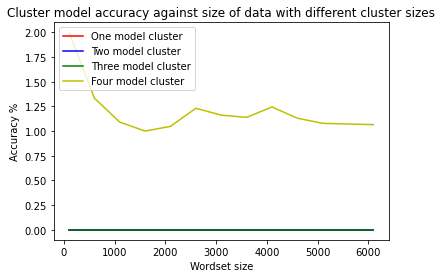

In [55]:
def clusterPredictX(sentence,mods):
    words=[sentence[-1],sentence[-2],sentence[-3],sentence[-4]]
    preds=[]
    for i,mod in enumerate(mods):
        s=""
        for w in words:
            s=w+"-"+s
        preds.append(mod.get_predict(s[:-1]))
    words=[]
    multiplier=1
    for dict in preds: #loop through all predictions
        if dict!="no word found":
            for key in dict:
                for i in range(dict[key]*multiplier):
                    words.append(key) #add multiple times if occurs multiple 
        multiplier+=1
    return most_common(words) #get most common word in list
sentence=train_words[0].split()

acc_=[]
sizes=[]
NUM = len(train_words)
num_models=4
for i in range(num_models): #get model sizes
    print(str(i+1)+" model")
    s=[]
    a=[]
    for word_set in range(100,601,500): #get sample sizes
        unigram=n_gram(train_words.copy()[0:word_set],1)
        bigram=n_gram(train_words.copy()[0:word_set],2)
        trigram=n_gram(train_words.copy()[0:word_set],3)
        quadgram=n_gram(train_words.copy()[0:word_set],4)
        models=[unigram,bigram,trigram,quadgram]
        mods=models[0:i+1] #get increasing size

        acc=0
        num=len(train_words[0:word_set])
        for k in range(num): #loop through words
            sent=train_words[k].split()
            if len(sent)>=5:
                pred=clusterPredictX(sent[0:-1],mods)
                if sent[-1]==pred: acc+=1 
        a.append(acc/num *100)
        s.append(word_set)
    acc_.append(a.copy())
    sizes.append(s.copy())

plt.title("Cluster model accuracy against size of data with different cluster sizes")
plt.plot(sizes[0],acc_[0],c="r",label="One model cluster")
plt.plot(sizes[1],acc_[1],c="b",label="Two model cluster")
plt.plot(sizes[2],acc_[2],c="g",label="Three model cluster")
plt.plot(sizes[3],acc_[3],c="y",label="Four model cluster")
plt.ylabel("Accuracy %")
plt.xlabel("Wordset size")
plt.legend(loc="upper left")
plt.show()

In [51]:
acc_[1]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]